#  Mental-RoBERTa
**Autora:** Antonia Estefane Ribeiro Veras

**Orientador:** Adonias Caetano de Oliveira

**Instituição:** IFCE

**Dataset disponível em:**


## Instalação de Pacotes

In [ ]:
!pip install Unidecode

In [ ]:
!pip install wordcloud

In [ ]:
#hide
!pip install transformers

In [ ]:
!pip install lime

## Importação de Bibliotecas

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from lime.lime_text import LimeTextExplainer

In [ ]:
#text preprocessing libraries
import pandas as pd
import re
from unidecode import unidecode
from string import punctuation
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
#text classification libraries
from transformers import BertTokenizer, BertForSequenceClassification
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from scipy.special import expit


## Montagem do Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregamento do Dataset

In [ ]:
url = 'https://drive.google.com/file/d/1dPGeH22_-4XQyEDTXl3039p4JlYmXAuO/view?usp=sharing'
file_id = url.split('/')[-2]
read_url='https://drive.google.com/uc?id=' + file_id

# read the data
dataset = pd.read_csv(read_url,  index_col=0)

dataset = dataset[['selftext', 'is_suicide']]
dataset = dataset.rename(columns={'selftext': 'text', 'is_suicide': 'class'})

# display the first 5 rows
dataset.head()

text  class
0  Hi I don't really know how to phrase this situ...      0
1  i have been so depressed these past couple wee...      1
2  Hi..I don't know where else to go. I am devast...      0
3  The shit like “it will get better, everyone is...      1
4  I wish I was prettier. I wish I didn’t feel li...      0

In [ ]:
dataset.shape

(1895, 2)

## Pré-Processamento de Texto

In [ ]:
nltk.download('rslp')
nltk.download('stopwords')
stopwords_list = stopwords.words("english")
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
'''
# Defina um dicionário de mapeamento para suas classes
class_mapping = {'non-suicide': 0, 'suicide': 1}

# Mapeie as classes para os valores numéricos
dataset['class'] = dataset['class'].map(class_mapping)

# Verifique se a transformação ocorreu corretamente
dataset.head()
'''

"\n# Defina um dicionário de mapeamento para suas classes\nclass_mapping = {'non-suicide': 0, 'suicide': 1}\n\n# Mapeie as classes para os valores numéricos\ndataset['class'] = dataset['class'].map(class_mapping)\n\n# Verifique se a transformação ocorreu corretamente\ndataset.head()\n"

In [ ]:
data_process = dataset.copy()

In [ ]:
dataset.head()

text  class
0  Hi I don't really know how to phrase this situ...      0
1  i have been so depressed these past couple wee...      1
2  Hi..I don't know where else to go. I am devast...      0
3  The shit like “it will get better, everyone is...      1
4  I wish I was prettier. I wish I didn’t feel li...      0

In [ ]:
import numpy as np

# Obtendo os textos originais
old_texts = data_process["text"]
new_texts = []

for text in old_texts:
    # Verifique se o texto não é um valor nulo (NaN)
    if isinstance(text, str):
        # Converte para minúsculas
        text = text.lower()
        # Remove menções (padrão do Twitter)
        text = re.sub('@[^\s]+', '', text)
        # Remove caracteres especiais do HTML
        text = re.sub('<[^<]+?>','', text)
        # Remove dígitos
        text = ''.join(c for c in text if not c.isdigit())
        # Remove URLs
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
        # Remove pontuação
        text = ''.join(c for c in text if c not in punctuation)
        # Remove stopwords
        text = ' '.join([word for word in text.split() if word not in stopwords_list])
        # Remove aspas duplas e simples
        text = text.replace("\"", "").replace("'", "")
        # Remove caracteres acentuados
        text = unidecode(text)
        # Adiciona o texto pré-processado à lista
        new_texts.append(text)
    else:
        # Se o texto for um valor nulo, você pode optar por ignorá-lo ou realizar outra ação adequada
        new_texts.append("")  # Aqui estou adicionando uma string vazia como um texto substituto

# Atualiza a coluna "text" com os textos pré-processados
data_process["text"] = new_texts


In [ ]:
data_process

text  class
0    hi dont really know phrase situation ill try l...      0
1    depressed past couple weeks ever since got bac...      1
2    hii dont know else go devastated right feeling...      0
3    shit like "it get better everyone purpose need...      1
4    wish prettier wish didn't feel like burden wis...      0
..                                                 ...    ...
374                      don't wanna live anymore yeah      0
375  i've learned life fucking sad sometimes start ...      0
376  thats nothing gotten better ive tried hard got...      1
377  first time im going course recently hit really...      0
378  fight fiancee potential ending relationship li...      1

[1895 rows x 2 columns]

## Visualização dos Dados

<Axes: xlabel='class', ylabel='count'>

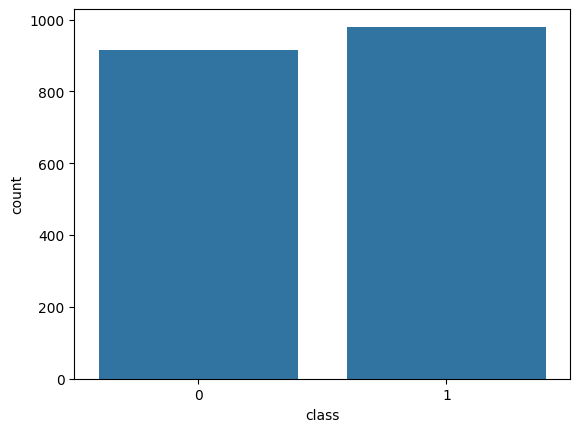

In [ ]:
sns.countplot(x = data_process['class'])

## Balanceamento dos Dados

<Axes: xlabel='class', ylabel='count'>

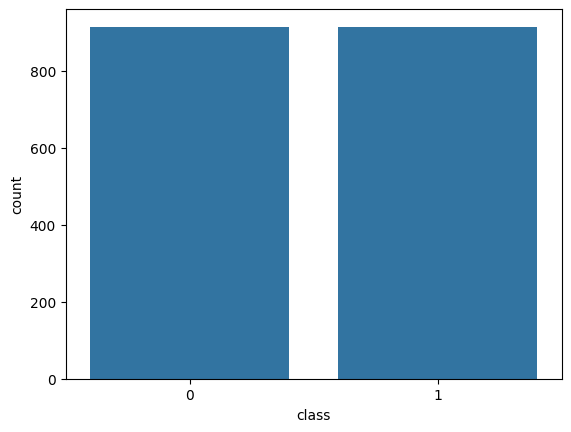

In [ ]:
rus = RandomUnderSampler(random_state= 0)
X_bal, Y_bal = rus.fit_resample(data_process[['text']], data_process['class'])
sns.countplot(x = Y_bal)

## Criação da Wordcloud

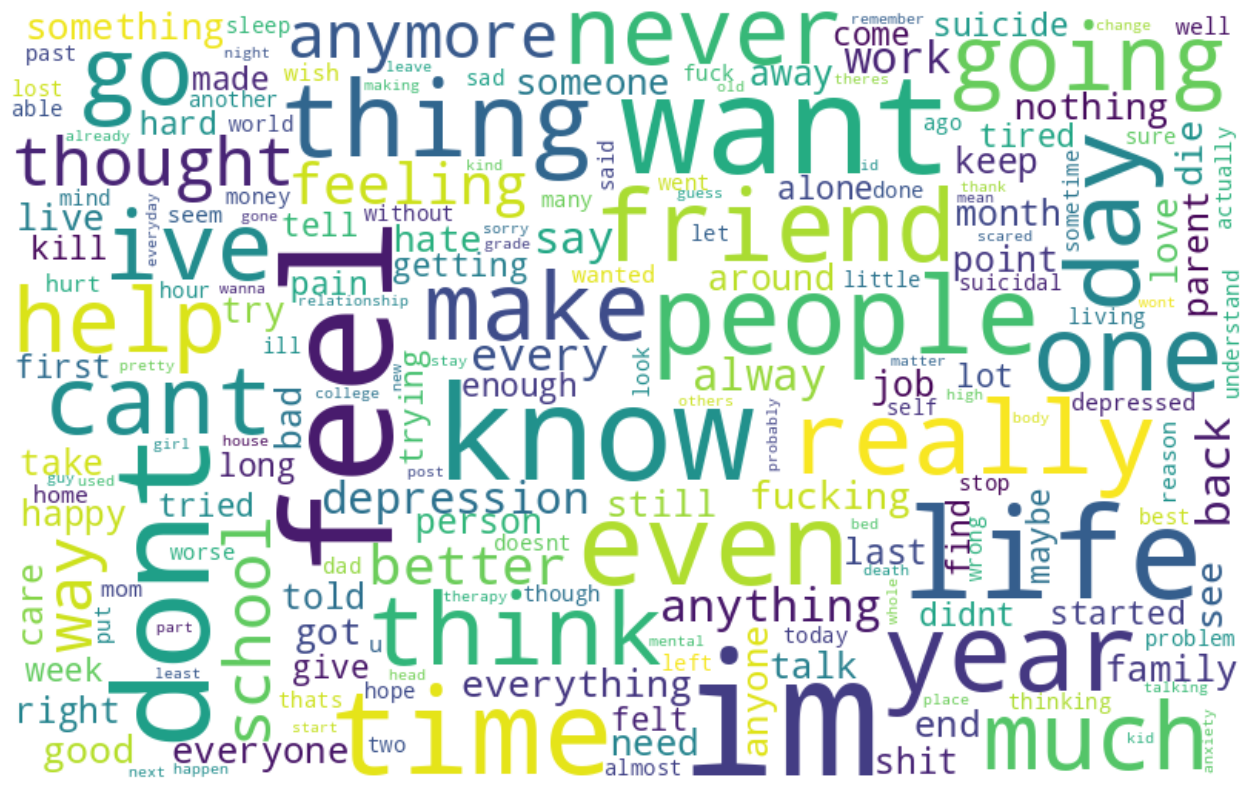

In [ ]:
new_texts = data_process["text"]
all_words = ' '.join([text for text in new_texts])
word_cloud = WordCloud(width= 800, height= 500, max_font_size = 110, background_color="white", collocations = False).generate(all_words)
plt.figure(figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Divisão dos Dados em Conjuntos de Treinamento, Validação e Teste

In [ ]:
train_df, test_df, train_label, test_label = train_test_split(X_bal, Y_bal, test_size=0.20, random_state=42)

In [ ]:
train_df, valid_df, train_label,  valid_label = train_test_split(train_df, train_label, test_size=0.20, random_state=42)

In [ ]:
label_names = ['non-suicide', 'suicide']
label_names

['non-suicide', 'suicide']

## Inicialização do Tokenizador e do Modelo

In [ ]:
PRETRAINED_LM = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

## Definição de Funções Auxiliares

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

## Preparação dos dados para o treinamento do modelo

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

In [ ]:
import torch
train_y = torch.LongTensor(train_label.values)
valid_y = torch.LongTensor(valid_label.values)
test_y = torch.LongTensor(test_label.values)
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([1171]), torch.Size([293]), torch.Size([366]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
train_label.unique()

array([0, 1])

In [ ]:
from transformers import BertForSequenceClassification
N_labels = len(train_label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.to(device)

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Best results: 07 and 08
EPOCHS = 7
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

## Treinamento do modelo

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

74/74 train loss: 0.6996205634361988 
19/19 val loss: 0.6894298007613734 
Epoch:  2


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

74/74 train loss: 0.6869144842431352 
19/19 val loss: 0.6846039891242981 
Epoch:  3


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

74/74 train loss: 0.6820639903480942 
19/19 val loss: 0.6763905851464522 
Epoch:  4


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

74/74 train loss: 0.668803712000718 
19/19 val loss: 0.6647608186069288 
Epoch:  5


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

74/74 train loss: 0.658544963276064 
19/19 val loss: 0.6575426584795901 
Epoch:  6


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

74/74 train loss: 0.6473305467012767 
19/19 val loss: 0.6518304693071466 
Epoch:  7


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

74/74 train loss: 0.6414784184984259 
19/19 val loss: 0.6500731047831083 


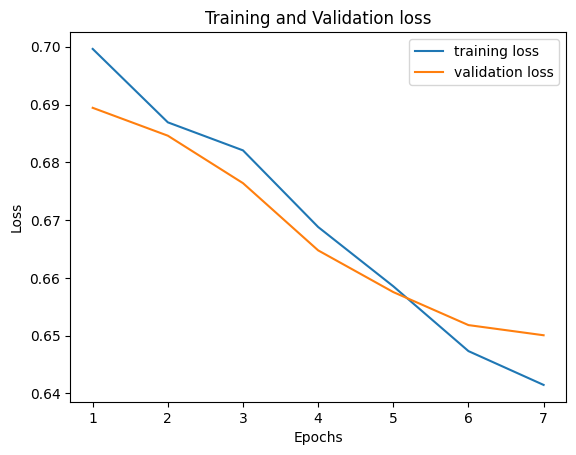

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Avaliação do Modelo

In [ ]:
model.eval()
test_pred = []
test_loss= 0

with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')


print(classification_report(test_pred, test_label.to_numpy(),target_names=label_names))


classifiation report
              precision    recall  f1-score   support

 non-suicide       0.64      0.59      0.61       192
     suicide       0.58      0.64      0.61       174

    accuracy                           0.61       366
   macro avg       0.61      0.61      0.61       366
weighted avg       0.61      0.61      0.61       366



In [ ]:
from scipy.special import expit

model.eval()
probabilities = []

with torch.no_grad():
  for step_num, batch_data in tqdm(enumerate(test_dataloader)):
      input_ids, att_mask, labels = [data.to(device) for data in batch_data]
      output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

      prob = expit(output.logits.cpu().detach().numpy())

      probabilities.append( prob )

probabilities = np.concatenate(probabilities)

0it [00:00, ?it/s]

In [ ]:
probabilities

array([0.53167665, 0.5071285 , 0.493936  , 0.492118  , 0.4867468 ,
       0.4824152 , 0.5812469 , 0.6348886 , 0.47566047, 0.4798185 ,
       0.47051606, 0.4937039 , 0.4605366 , 0.53403115, 0.5817257 ,
       0.5303479 , 0.47283056, 0.4515948 , 0.48228672, 0.4622766 ,
       0.6669635 , 0.504231  , 0.46906352, 0.51024413, 0.45696387,
       0.66468525, 0.62237495, 0.4718224 , 0.46261057, 0.5253797 ,
       0.46743968, 0.47923604, 0.4843098 , 0.4783475 , 0.489457  ,
       0.52394986, 0.44201982, 0.5088288 , 0.4645008 , 0.5452942 ,
       0.52364457, 0.52364457, 0.4649493 , 0.56173027, 0.52364457,
       0.46544087, 0.4623921 , 0.5945703 , 0.47837958, 0.47238418,
       0.50340134, 0.46369427, 0.47175205, 0.49049842, 0.5338759 ,
       0.49061295, 0.5763495 , 0.5029967 , 0.5258104 , 0.50200385,
       0.4839055 , 0.5915716 , 0.47331926, 0.504996  , 0.57189935,
       0.58433264, 0.52364457, 0.52364457, 0.54015374, 0.5557939 ,
       0.59585816, 0.559611  , 0.4988289 , 0.5528162 , 0.50633

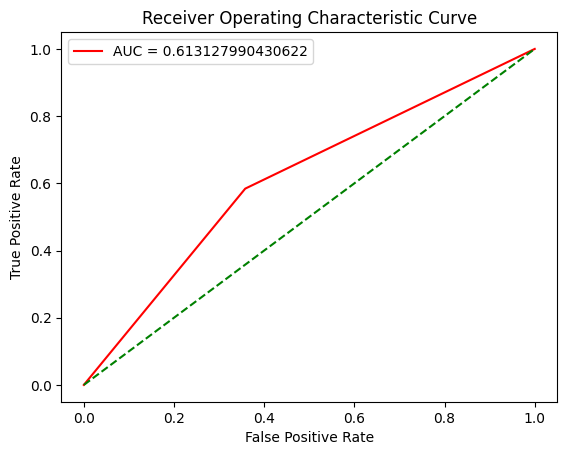

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(fper, tper, AUC):
    plt.plot(fper, tper, color="red", label=f"AUC = {AUC}")
    plt.plot([0, 1], [0, 1], color="green", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend()
    plt.show()


fper, tper, thresholds = roc_curve(test_label.to_numpy(), test_pred.to_numpy())
AUC = auc(fper, tper)
plot_roc_curve(fper, tper, AUC)

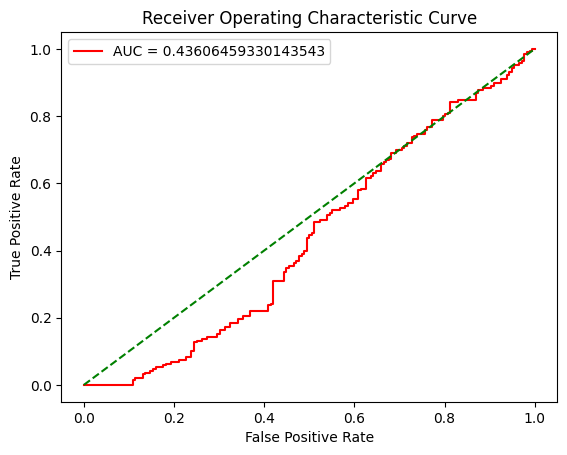

In [ ]:
fper, tper, thresholds = roc_curve(test_label.to_numpy(), probabilities[::,1])
AUC = auc(fper, tper)
plot_roc_curve(fper, tper, AUC)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

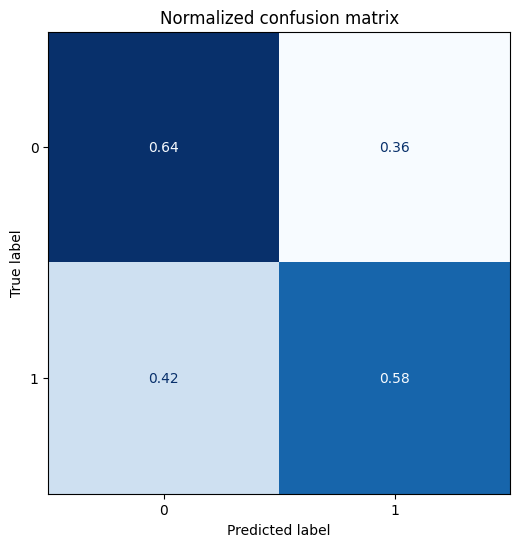

In [ ]:
plot_confusion_matrix(test_pred, test_label.to_numpy())

In [ ]:
test_df['pred'] = test_pred
test_df['label'] = test_label
test_df['prob'] = probabilities
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(142, 4)


text  label  pred
382   cant bear fucking theres choice carcinoma vet ...      0     1
1197  it's average story everyone's heard friends br...      1     0
643   left shattered memories long lost pain left tu...      0     1
275   youre people screen im never going interact do...      0     1
1251  used frequent sub time time banned one places ...      1     0
188   dont deserve love im fucked im mess reason don...      0     1
966   every single day thought keeps driving road wa...      1     0
610   can't need remember telling final therapist i'...      0     1
398   give one good reason kill right whole world go...      0     1
506   take months work due season ending also pyscho...      0     1

## **Saving results**

In [ ]:
import shutil

In [ ]:
#hide
test_df.to_csv("test_results_BERTimbauLarge.csv",index= False)

In [ ]:
shutil.copy('/content/test_results_BERTimbauLarge.csv', '/content/drive/MyDrive/test_results_BERTimbauLarge.csv')

'/content/drive/MyDrive/test_results_BERTimbauLarge.csv'

In [ ]:
MODEL_PATH = "BERTimbauLarge.bin"
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
shutil.copy('/content/BERTimbauLarge.bin', '/content/drive/MyDrive/BERTimbauLarge.bin')

'/content/drive/MyDrive/BERTimbauLarge.bin'

## Interpretabilidade do Modelo com Lime

In [ ]:
def createDataloader(text):
  test_input_ids, test_att_masks = encode([text])
  BATCH_SIZE = 16
  test_y = torch.LongTensor([0])
  test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)
  return test_dataloader

In [ ]:
def predict(text, labels_names):
    model.eval()
    test_dataloader = createDataloader(text)

    with torch.no_grad():
        for step_num, batch_data in tqdm(enumerate(test_dataloader)):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

            logits = output.logits.cpu().detach().numpy()
            index_pred = np.argmax(logits, axis=-1)[0]
            probabilities = expit(logits)[0]

    df = pd.DataFrame(columns=['Label', 'Probabilidade'])
    df['Label'] = labels_names
    df['Probabilidade'] = probabilities

    return index_pred, labels_names[index_pred], df

In [ ]:
labels_names = ['non-suicide', 'suicide']
text = 'think better night posts pretty shit shitposts rn like 7 ish hours making shitty posts sorry'
index_pred, label, df = predict(text, labels_names)

0it [00:00, ?it/s]

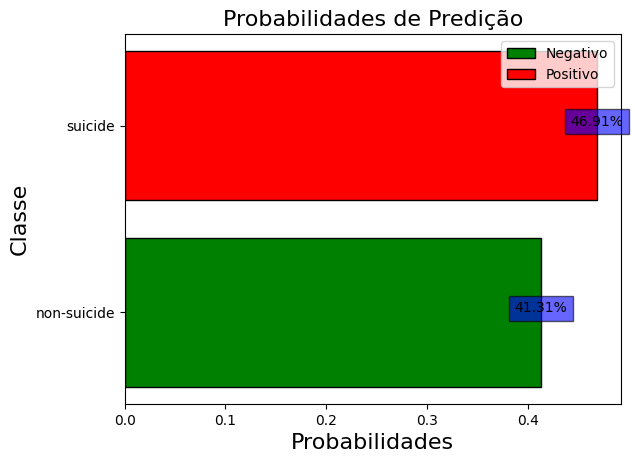

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def addlabels(x, y):
    for i in range(len(x)):
        plt.text(y[i], i, str(f'{y[i]*100:0.2f}%'), ha='center', bbox=dict(facecolor='blue', alpha=.6))

plt.clf()

pos = np.arange(len(df['Label'].values))
probabilidades = df['Probabilidade'].values

# Definir as cores para cada classe
colors = df['Label'].map({'non-suicide': 'g', 'suicide': 'r'})

# Criar o gráfico de barras
fig = plt.barh(pos, probabilidades, color=colors, edgecolor='black')
plt.yticks(pos, df['Label'])  # Exibir cada classe no eixo y
plt.legend(fig, [str(i) for i in ['Negativo', 'Positivo']])  # Exibir a legenda de cada classe (Positivo ou Negativo)
plt.xlabel('Probabilidades', fontsize=16)
plt.ylabel('Classe', fontsize=16)
addlabels(pos, probabilidades)  # Chamar a função para adicionar rótulos de valores
plt.title('Probabilidades de Predição', fontsize=16)
plt.show()


In [ ]:
def predict_proba(sentences):
  model.eval()
  probabilities = []

  test_input_ids, test_att_masks = encode(sentences)
  BATCH_SIZE = 16
  test_y = torch.LongTensor([0] * len(sentences))
  test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

  with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        probabilities.append(expit(output.logits.cpu().detach().numpy()))

  probabilities = np.concatenate(probabilities)

  return probabilities

In [ ]:
labels_names = ['non-suicide', 'suicide']

In [ ]:
explainer = LimeTextExplainer(class_names = labels_names)

In [ ]:
exp = explainer.explain_instance('know 7 months self harm free urge gets stronger stronger every day past days shit family stresses especially nephew 12 mum full custody told go kill numerous times wish easy partners family stresses especially past days stress trigger want scream cry live near woods could go scream till ca possibly scream anymore cops probably get called oh knows depression really know feeling moment would want come make sure ok fucking annoying annoys time small stupid things even know going post', classifier_fn = predict_proba, num_features = 10)

0it [00:00, ?it/s]

In [ ]:
exp.show_in_notebook(text = True)

In [ ]:
from IPython.core.display import display, HTML
display(HTML(exp.as_html()))

In [ ]:
exp = explainer.explain_instance('feeling depressed stressed someone actually caring talk feel like dearth caring affectionate people planet everyone terrible indifferent write paragraphs paragraphs text make someone feel important never get return', classifier_fn = predict_proba, num_features = 10)

0it [00:00, ?it/s]

In [ ]:
exp.show_in_notebook(text = True)

In [ ]:
from IPython.core.display import display, HTML
display(HTML(exp.as_html()))

In [ ]:
def execute_classify(input):

  if model != None:
    test_pred = predict(input)
    label = labels_names[test_pred[0]]
    return f"A classe prevista foi: {label}"
  else:
    return "Não há texto ou modelo para classificação!"

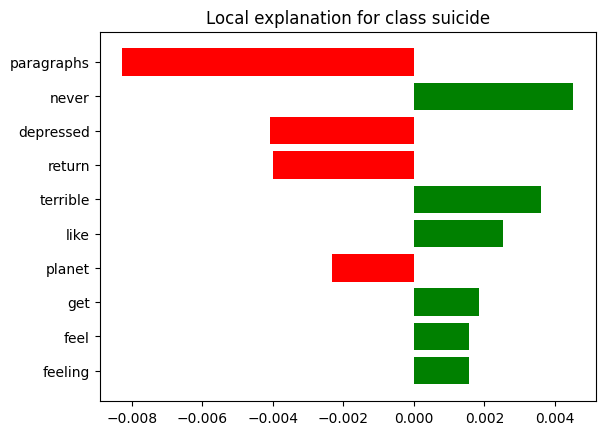

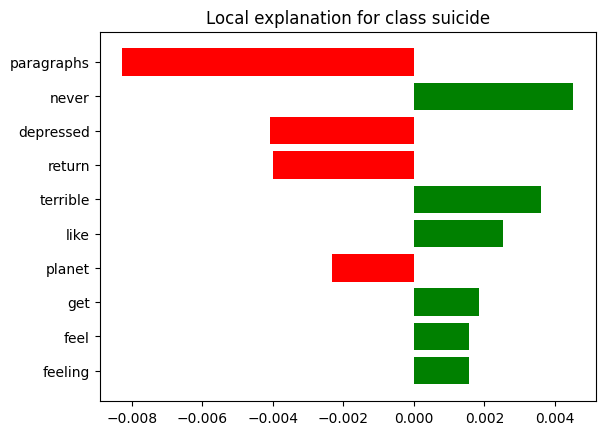

In [ ]:
exp.as_pyplot_figure()

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')